# Amazon Redset Workload Forecasting

## What is Redset?
Redset is a dataset released by Amazon in 2024, comprising three months of user query metadata from a selected sample of Amazon Redshift instances. It includes query metadata for **200 provisioned and 200 serverless instances**, offering insights into user interactions with these database services. While not representative of the entire Redshift fleet, Redset serves as a valuable resource for developing **new benchmarks and exploring machine learning techniques**, such as **workload forecasting**, tailored to these specific workloads.

## What we perform in this notebook?

In this notebook, we analyze **Amazon Redset**, a dataset containing query metadata from Amazon Redshift instances, to explore **workload forecasting techniques** for **intelligent resource scaling**. Our primary objectives are:

### 1. Baseline Model Evaluation
- We evaluate **traditional forecasting baselines**, such as:
  - **AutoGluon DeepAR**
  - **Seasonal Naive Models**
- These models establish reference points for **workload prediction**.

### 2. Development of RNN-based Forecasting Models
- We implement **Recurrent Neural Network (RNN)-based models** to improve **forecasting accuracy**.
- These models aim to **capture complex workload patterns** and **improve upon the baselines**.

### 3. Comparison Between Baselines and RNN-based Approaches
- Using the **Redset dataset**, we compare the performance of our **custom RNN models** with:
  - **AutoGluon DeepAR**
  - **Statistical forecasting methods** (e.g., ARIMA, ETS)
- We use metrics such as **Q-error** and **forecast accuracy** to assess improvements.

---

### Reference
For more details on the forecasting methodologies and benchmark comparisons, we refer to the **attached paper: "Forecasting Algorithms for Intelligent Resource Scaling: An Experimental Analysis"**.  
This paper provides insights into **workload forecasting challenges**, evaluation metrics, and strategies for improving predictive accuracy in cloud environments.

In [1]:
import pandas as pd
from datetime import datetime
from utility.helpers import DataManager
import visualization
from utility.baseline_models import DeepAR
import matplotlib.pyplot as plt
import seaborn as sns
datamanager = DataManager('provisioned', 96)

/Applications/miniconda/envs/mxnet310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load the data
data = datamanager.load_data()
# Convert timestamp to datetime
data['timestamp'] = pd.to_datetime(data['timestamp'])
# Sort the data by timestamp
data = data.sort_values('timestamp')

In [3]:
# Visualize data
visualization.visualize_data(data)
data

,instance_id,timestamp,query_count,runtime,bytes_scanned
48872,96,2024-03-01 00:00:00,1,17.0,0.0
147290,96,2024-03-01 01:00:00,1,20.0,0.0
98018,96,2024-03-01 02:00:00,1,17.0,0.0
147330,96,2024-03-01 03:00:00,4,245.0,136.0
98055,96,2024-03-01 04:00:00,1,17.0,0.0
...,...,...,...,...,...
146949,96,2024-05-29 19:00:00,4,3488.0,1147.0
146983,96,2024-05-29 20:00:00,4,36908.0,26665.0
48624,96,2024-05-29 21:00:00,1,17.0,0.0
97748,96,2024-05-29 22:00:00,1,18.0,0.0


In [4]:
# Split into training and test data:
# Following the approach in the paper (p. 132), for a cluster with N weeks of data, 
# the first train-test split includes N-2 weeks for training and the following week 
# for testing. The second train-test split contains the first N-1 weeks for training 
# and the following week for testing, representing a scenario of re-training a model 
# each week and forecasting for the next week

train1, test1, train2, test2 = datamanager.train_test_split(data)

print(f"train1 shape: {train1.shape}")
print(f"test1 shape: {test1.shape}")
print(f"train2 shape: {train2.shape}")
print(f"test2 shape: {test2.shape}")

print(train1.iloc[-1])
print(test1.iloc[0])
print(train1.iloc[-1])
print(test1.iloc[0])

train1 shape: (1919, 5)
test1 shape: (168, 5)
train2 shape: (2087, 5)
test2 shape: (48, 5)
instance_id                       96
timestamp        2024-05-19 23:00:00
query_count                        1
runtime                         19.0
bytes_scanned                    0.0
Name: 141583, dtype: object
instance_id                       96
timestamp        2024-05-20 00:00:00
query_count                       13
runtime                      20678.0
bytes_scanned                 3045.0
Name: 190321, dtype: object
instance_id                       96
timestamp        2024-05-19 23:00:00
query_count                        1
runtime                         19.0
bytes_scanned                    0.0
Name: 141583, dtype: object
instance_id                       96
timestamp        2024-05-20 00:00:00
query_count                       13
runtime                      20678.0
bytes_scanned                 3045.0
Name: 190321, dtype: object


## Baseline Model: DeepAR

In [5]:
train1.head()

,instance_id,timestamp,query_count,runtime,bytes_scanned
48872,96,2024-03-01 00:00:00,1,17.0,0.0
147290,96,2024-03-01 01:00:00,1,20.0,0.0
98018,96,2024-03-01 02:00:00,1,17.0,0.0
147330,96,2024-03-01 03:00:00,4,245.0,136.0
98055,96,2024-03-01 04:00:00,1,17.0,0.0


In [6]:
# Define the forecast horizon (e.g., forecast the next 24 hours)
prediction_length = 48

# Instantiate the DeepAR model using AutoGluon
model = DeepAR(prediction_length=prediction_length, freq="H")

# Train the model on the training data
model.train(train1, target_column="query_count")

# Generate predictions on the test data
predictions_df = model.predict(test1, target_column="query_count")
print("Predictions:")
print(predictions_df.head())

# Evaluate the model on the test data
evaluation_results = model.evaluate(test1, target_column="query_count")
print("Evaluation Metrics:")
print(evaluation_results)

# Save the trained model to disk
model.save_model()

/Applications/miniconda/envs/mxnet310/lib/python3.10/site-packages/autogluon/timeseries/predictor.py:197: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  std_freq = pd.tseries.frequencies.to_offset(self.freq).freqstr
Frequency 'H' stored as 'h'
Beginning AutoGluon training...
AutoGluon will save models to '/Users/sagnikdas/GitHub/WF-ML/AutogluonModels/ag-20250216_145253'


Initializing DeepARAutogluonTS Model...
Training started using DeepAR...


=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.10.16
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 24.3.0: Thu Jan  2 20:24:06 PST 2025; root:xnu-11215.81.4~3/RELEASE_ARM64_T8103
CPU Count:          8
GPU Count:          0
Memory Avail:       1.70 GB / 8.00 GB (21.3%)
Disk Space Avail:   18.37 GB / 228.27 GB (8.0%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'freq': 'h',
 'hyperparameters': {'DeepAR': {'batch_size': 32,
                                'context_length': 48,
                                'dropout_rate': 0.1,
                                'epochs': 50,
                                'hidden_size': 40,
                                'learning_rate': 0.001,
                                'num_layers': 2}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 48,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 

Training completed using DeepAR.
Predictions:
            timestamp       mean  lower_bound  upper_bound
0 2024-05-27 00:00:00  -1.873438   -72.499710    73.691071
1 2024-05-27 01:00:00   5.820815   -55.328389    73.278764
2 2024-05-27 02:00:00   1.443295   -90.715264    70.966052
3 2024-05-27 03:00:00   4.711687   -72.889924    83.557624
4 2024-05-27 04:00:00  10.594169   -64.716015    79.660094
Evaluation Metrics:
{'WQL': -0.8950163434742218}
Model saved successfully.


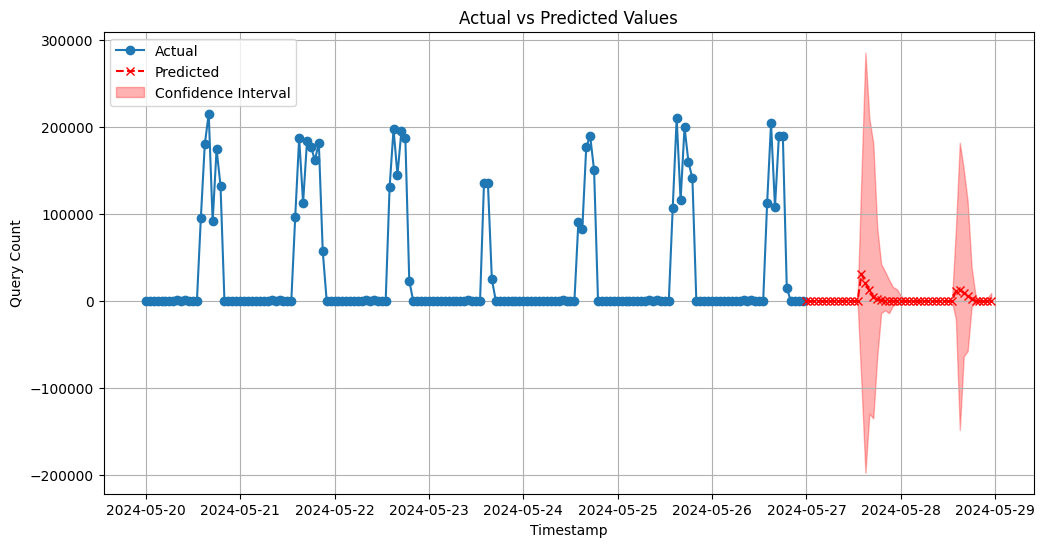

In [7]:
import matplotlib.pyplot as plt
import pandas as pd

# Optionally, convert timestamps to datetime if they aren't already
test1['timestamp'] = pd.to_datetime(test1['timestamp'])
predictions_df['timestamp'] = pd.to_datetime(predictions_df['timestamp'])

plt.figure(figsize=(12, 6))

# Plot the actual test data
plt.plot(test1['timestamp'], test1['query_count'], label='Actual', marker='o', linestyle='-')

# Plot the predicted mean values
plt.plot(predictions_df['timestamp'], predictions_df['mean'], label='Predicted', marker='x', linestyle='--', color='red')

# Fill the confidence interval if available
plt.fill_between(predictions_df['timestamp'], 
                 predictions_df['lower_bound'], 
                 predictions_df['upper_bound'], 
                 color='red', alpha=0.3, label='Confidence Interval')

plt.xlabel('Timestamp')
plt.ylabel('Query Count')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()